In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import itertools as it
from typing import Callable, Optional


In [2]:
def nolift_bank_angle_fn(t: float, state: np.array, parameters: dict):
    # Ballistic trajectory, bank angle = 90 deg for zero lift
    return np.pi/2

def ballistic_traj_eom(t: float, 
                       state: np.array, 
                       parameters: dict,
                       bank_angle_fn: Callable[[float, np.array, dict], float]
                      ):
    h, s, V, gam = state
    u = bank_angle_fn(t, state, parameters)
    
    rho0 = parameters['rho0']
    H = parameters['H']
    beta = parameters['beta']   # m/(Cd * Aref)
    LD = parameters['LD']
    R_m = parameters['R_m']
    g = parameters['g']
    
    V2 = V*V
    rho = rho0 * np.exp(-h/H) 
    D_m = rho * V2 / (2 * beta)  # Drag Acceleration (D/m)
    
    return np.array([V * np.sin(gam),  # dh/dt
                     V * np.cos(gam),  # ds/dt
                     -D_m - g*np.sin(gam),  # dV/dt
                     (V2 * np.cos(gam)/(R_m+h) + D_m*LD*np.cos(u) - g*np.cos(gam))/V] # dgam/dt
                   )

def altitude_stop_event(t, state, parameters, _):
    """Defines stopping condition for numerical integration"""
    return state[0] - 20e3  # 20km altitude

altitude_stop_event.terminal = True
altitude_stop_event.direction = -1

In [3]:
h0 = 120e3; # Entry altitude
V0 = 5500;  # Entry velocity
gamma0_deg = -14.5; # Entry flight path angle
s0 = 0

parameters = {'H': 11.1e3,
              'rho0': 0.020, # kg/m^3
              'beta': 120,
              'LD': 0.24,
              'R_m': 3380e3,
              'g': 3.73}

X0 = np.array([h0, s0, V0, np.deg2rad(gamma0_deg)])
t0 = 0
tf = 500.
tspan = np.linspace(t0, tf, 1001)

ballistic_traj_eom(0, X0, parameters, nolift_bank_angle_fn)

array([-1.37709002e+03,  5.32481202e+03,  8.83046605e-01,  8.64794736e-04])

In [4]:
output = solve_ivp(ballistic_traj_eom, 
                   [t0, tf], 
                   X0, 
                   args=(parameters, nolift_bank_angle_fn), 
                   t_eval=tspan,
                   rtol=1e-5, events=altitude_stop_event)
print(output.y.shape)

(4, 188)


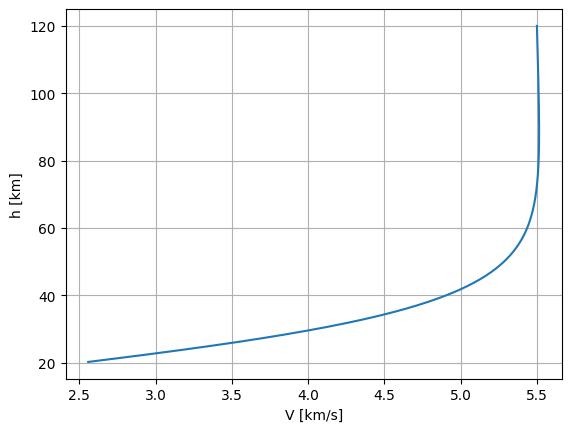

In [5]:
plt.plot(output.y[2,:]/1e3, output.y[0,:]/1e3)
plt.xlabel('V [km/s]')
plt.ylabel('h [km]')
plt.grid(True)
plt.show()

# Simplifying the Simulator interface

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
from typing import Callable, Optional

class Trajectory:
    """Data structure for holding the result of a simulation run"""
    def __init__(self, t: float, X: np.array, u: np.array, parameters: dict):
        self.t = t
        self.X = X
        self.u = u
        self.parameters = parameters
        
    def eval_scalar(self, fn: Callable[[float, np.array], float]):
        """Applies a function that takes in as its arguments a values of
           t and X at a single instant in time and returns a scalar
        """
        return np.fromiter(
                    it.starmap(
                       fn, 
                       zip(self.t, self.X)
                    ),
               dtype=np.float64
        )

def simulate_entry_trajectory(eom: Callable[[float, np.array], np.array], 
                              t0: float, 
                              tf: float, 
                              X0: np.array, 
                              h_f: float, 
                              params: dict,
                              bank_angle_fn: Callable[[float, np.array, dict], float],
                              t_eval: Optional[np.array] = None) -> Trajectory:

    altitude_stop_event = lambda t, X, params, _: X[0] - h_f
    altitude_stop_event.terminal = True
    altitude_stop_event.direction = -1
    
    output = solve_ivp(eom, 
                   [t0, tf], 
                   X0, 
                   args=(params, bank_angle_fn), 
                   t_eval=t_eval,
                   rtol=1e-5, events=altitude_stop_event)
    
    # loop over output and compute bank angle for each timestep
    num_steps = len(output.t)

    u = np.zeros(num_steps)
    for i, (t, X) in enumerate(zip(output.t, output.y.T)):
        u[i] = bank_angle_fn(t, X, params)
        
    # Transpose y so that each state is in a separate column and each row 
    # represents a timestep
    return Trajectory(output.t, output.y.T, u, params)

In [9]:
traj = simulate_entry_trajectory(ballistic_traj_eom, t0, tf, X0, 20e3, parameters, nolift_bank_angle_fn, tspan)